In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [27]:
import datetime as dt
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,inspect

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Climate Analysis

In [11]:
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [12]:
inspector=inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


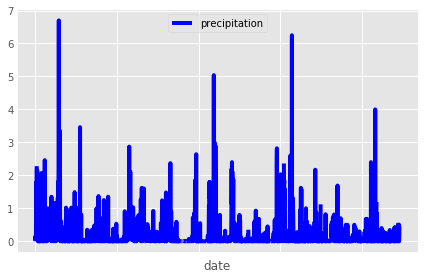

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from today
#most recent date (2017-08-23)
most_recent = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
year_ago=dt.date(2017, 8, 23)-dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores # Sort the dataframe by date

data_precipitation=session.query(Measurement.date,Measurement.prcp).\
        filter(Measurement.date>=year_ago).\
        order_by(Measurement.date).all()
data_precipitation

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df=pd.DataFrame(data_precipitation)
precipitation_df.set_index('date').head()
# Use Pandas Plotting with Matplotlib to plot the data

plt.style.use('ggplot')
precipitation_df.plot('date', 'prcp',color="blue")
plt.xlabel("date")
plt.xticks(rotation=45)
plt.legend(["precipitation"],loc=9)
plt.tight_layout()
plt.savefig("datesVsprecipitation.png")
plt.show()


In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()


,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
inspector=inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [17]:
engine.execute('SELECT * FROM station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [62]:
# How many stations are available in this dataset?
stations_available=session.query(func.count(Station.station)).all()
print(f'The number of available stations in dataset: {stations_available}')

The number of available stations in dataset: [(9,)]


In [63]:
# What are the most active stations?
# List the stations and the counts in descending ordsumer.
list_stations=session.query(Station.station,func.count(Measurement.station)).\
              filter(Station.station==Measurement.station).\
              group_by(Station.station).\
              order_by(func.count(Measurement.station).desc()).all()
print(f'Most active stations are{list_stations}')

Most active stations are[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [65]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
print(f'The Minimum, Average and maxium temperature for most active station {session.query(Station.name,func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
              filter(Station.station==Measurement.station).\
              filter(Station.station=="USC00519281").all()}')


The Minimum, Average and maxium temperature for most active station [('WAIHEE 837.5, HI US', 54.0, 85.0, 71.66378066378067)]


In [66]:
# Choose the station with the highest number of temperature observations.
list_stations_temp=session.query(Station.station,func.count(Measurement.tobs)).\
              filter(Station.station==Measurement.station).\
               group_by(Station.station).\
              order_by(func.count(Measurement.tobs).desc()).all()
list_stations_temp[0][0]

'USC00519281'

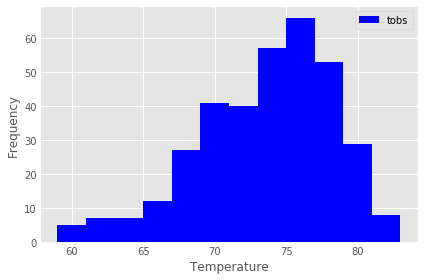

In [67]:
# Choose the station with the highest number of temperature observations.
query_station=list_stations[0][0]
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_records=session.query(Measurement.date,Measurement.tobs).\
                    filter(Measurement.station==query_station).\
                    filter(Measurement.date>=year_ago).\
                    order_by(Measurement.tobs.desc()).all()
frequency= [temperature_record[0] for temperature_record in temperature_records]
temperature = [temperature_record[1]  for temperature_record in temperature_records]
df = pd.DataFrame(temperature_records, columns=['Temperature', 'Frequency'])
df.set_index('Temperature', inplace=True )
df.plot.hist(color="blue",bins=12)
plt.xlabel("Temperature")
plt.legend(["tobs"],loc=1)
plt.tight_layout()
plt.savefig("TemperatureVsFrequency.png")
plt.show()

In [74]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    #TMIN, TAVG, and TMAX for a list of dates.
    min_temp = session.query(func.min(Measurement.tobs)).\
            filter(Measurement.date >=start_date).\
            filter(Measurement.date <=end_date).all()
        
    max_temp = session.query(func.max(Measurement.tobs)).\
                filter(Measurement.date >=start_date).\
            filter(Measurement.date <= end_date).all()
        
    avg_temp = session.query(func.avg(Measurement.tobs)).\
            filter(Measurement.date >=start_date).\
            filter(Measurement.date <= end_date).all()
    starting_date = str(input("Enter your start date (%Y-%m-%d): "))
    ending_date = str(input("Enter your end date (%Y-%m-%d): "))
    
    start_date =datetime.strptime(starting_date, '%Y-%m-%d').date()
    end_date =datetime.strptime(ending_date, '%Y-%m-%d').date()
        
    result = min_temp, avg_temp, max_temp
    return list(np.ravel(result))
    
    
    
    
#print(f'The Minimum, Average, Maximum Temperatures from start to end date are: {calc_temps("2012-02-28","2012-03-05")}')
print (f'The Minimum, Average, Maximum Temperatures from start to end date are: {calc_temps("2012-02-28","2012-03-05")}')


Enter your start date (%Y-%m-%d): 2012-02-28
Enter your end date (%Y-%m-%d): 2012-03-05
The Minimum, Average, Maximum Temperatures from start to end date are: [62.0, 69.57142857142857, 74.0]


In [76]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
temperatures=(calc_temps('2011-02-28', '2011-03-05'))
print (f'The Minimum, Average, Maximum Temperatures from start to end date year before  are: {temperatures}')

Enter your start date (%Y-%m-%d): 2011-02-28
Enter your end date (%Y-%m-%d): 2011-03-05
The Minimum, Average, Maximum Temperatures from start to end date year before  are: [61.0, 69.75510204081633, 75.0]


C:\Users\lalit\anaconda\Anaconda3\envs\pythondata\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


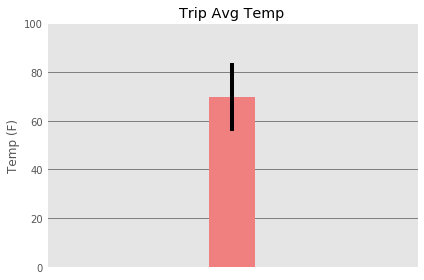

In [77]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
plt.title("Trip Avg Temp")
# Use the average temperature for the y value
Avg_temp=temperatures[1]
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
yerr = temperatures[2]-temperatures[0]
plt.bar(1,Avg_temp, color='lightcoral', width=0.3, yerr =yerr)
plt.xlim(-0.2, 2.2)
plt.ylim(0,100)
plt.axes().get_xaxis().set_visible(False)
plt.title('Trip Avg Temp')
plt.ylabel("Temp (F)")
plt.grid(color='grey')
plt.tight_layout()
plt.savefig("Trip Avg Temp.png")
plt.show()

In [78]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def weather_per_station():
    starting_date = str(input("Enter your start date (%Y-%m-%d): "))
    ending_date = str(input("Enter your end date (%Y-%m-%d): "))
    
    start_date =datetime.strptime(starting_date, '%Y-%m-%d').date()
    end_date =datetime.strptime(ending_date, '%Y-%m-%d').date()
    rainfall_weather_per_station=session.query(Station.station,Station.name,Station.latitude, Station.longitude,Station.elevation,Measurement.prcp).\
                            filter(Station.station==Measurement.station).\
                            filter(Measurement.date >=start_date).\
                            filter(Measurement.date <= end_date).\
                            group_by(Station.station).\
                            order_by(Measurement.prcp.desc()).all()
    return rainfall_weather_per_station
print(f'Rainfall per station is {weather_per_station()}')


Enter your start date (%Y-%m-%d): 2011-02-28
Enter your end date (%Y-%m-%d): 2011-03-05
Rainfall per station is [('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 1.42), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.6), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.4), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.29), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.26), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.26), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.22), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.13), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]


## Optional Challenge Assignment

In [79]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)
def daily_normals(date):
   
    query_date = str(input("Enter your query date (%Y-%m-%d): "))

    queried_date =datetime.strptime(query_date, '%Y-%m-%d').date()
    date= queried_date.strftime("%m-%d")         
    Tmin=session.query(func.min(Measurement.tobs)).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    Tmax=session.query(func.max(Measurement.tobs)).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    Tavg=session.query(func.avg(Measurement.tobs)).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    #sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    #result=session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    result = Tmin, Tavg, Tmax
    normals= list(np.ravel(result))
    return(normals)
    
print (f'Daily normals query date {query_date} for Specific month,day are {daily_normals("01-01")}')


Enter your query date (%Y-%m-%d): 2018-01-01
Daily normals query date 2018-01-01 for Specific month,day are [62.0, 69.15384615384616, 77.0]


In [82]:
# calculate the daily normals for your trip
#enter the trip starting and ending dates 
query_start_date =str(input("Enter your query start date (%Y-%m-%d): "))
query_end_date = str(input("Enter your query end date (%Y-%m-%d): "))
end_date =datetime.strptime(query_end_date, '%Y-%m-%d').date()
start_date =datetime.strptime(query_start_date, '%Y-%m-%d').date()
diff=end_date-start_date
days=diff.days
daterange = pd.date_range(start_date, end_date)
#storing the dates in list start_d
start_d=[]
for single_date in daterange:
    start=single_date.strftime("%Y-%m-%d")
    start_d.append(start)
# push each tuple of calculations into a list called `normals`
normals=[]
Day_mon=[]
for single_date in daterange:
    day_mon=single_date.strftime("%m-%d")
    Day_mon.append(day_mon)
    temp=daily_normals(Day_mon)
    normals.append(temp)
    
print(f'The list of dates on month and day format are {Day_mon}')
print(f'Daily normals for the query dates are:')
print(normals)

Enter your query start date (%Y-%m-%d): 2018-01-01
Enter your query end date (%Y-%m-%d): 2018-01-07
Enter your query date (%Y-%m-%d): 2018-01-01
Enter your query date (%Y-%m-%d): 2018-01-02
Enter your query date (%Y-%m-%d): 2018-01-03
Enter your query date (%Y-%m-%d): 2018-01-04
Enter your query date (%Y-%m-%d): 2018-01-05
Enter your query date (%Y-%m-%d): 2018-01-06
Enter your query date (%Y-%m-%d): 2018-01-07
The list of dates on month and day format are ['01-01', '01-02', '01-03', '01-04', '01-05', '01-06', '01-07']
Daily normals for the query dates are:
[[62.0, 69.15384615384616, 77.0], [60.0, 69.39622641509433, 77.0], [62.0, 68.9090909090909, 77.0], [58.0, 70.0, 76.0], [56.0, 67.96428571428571, 76.0], [61.0, 68.96491228070175, 76.0], [57.0, 68.54385964912281, 76.0]]


In [83]:
df_normals = pd.DataFrame(normals,columns=['Tmin', 'TAvg', 'Tmax'])
df_normals['Date']=start_d
df_normals.set_index('Date',inplace=True)
df_normals


,Tmin,TAvg,Tmax
Date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0
2018-01-06,61.0,68.964912,76.0
2018-01-07,57.0,68.543860,76.0


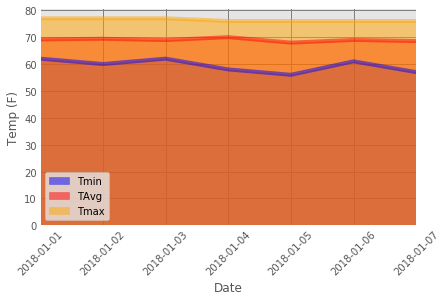

In [85]:
x=np.arange(0, len(df_normals))
#df_normals.plot.area(linewidth=1,use_index=True,stacked=False, colormap="plasma")
df_normals.plot.area(stacked=False, color=['blue', 'red', 'orange'])
plt.xticks( x, start_d ,rotation=45)
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel("Temp (F)")
plt.grid(color="grey")
plt.savefig("TempVstripdates.png")
plt.show()

